<a href="https://colab.research.google.com/github/AndresMontesDeOca/RegresionAvanzada/blob/main/Machete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MACHETE

#### Logbook

In [1]:
# Autor: Andres Montes de Oca

# 31/05/23 -> Creacion de la Notebook
# 31/05/23 -> Tests Normalidad, Homocedasticidad Residuos
# 06/06/23 -> Test No-autoorrelacion de Residuos
# 17/06/23 -> Transfomraciones Box Clox
# 19/06/23 -> Migrated to Google Colab
# 20/06/23 -> R Magic
# 22/06/23 -> Deteccion Outliers e Influyentes

In [2]:
# Instalacion de Paquetes
!pip install pingouin # No incluido en Google Colab
# !pip install scipy
# !pip install statsmodels

# Version rpy2 que no tiene problemas de compatibilidad
!pip install rpy2==3.5.1

# Cargamos Librerias y Datos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from scipy import stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tools.tools as smt
import math

# Ignorar Warnings
import warnings
warnings.filterwarnings('ignore')

# Asthetics
sns.set(style='ticks', context='notebook', palette='colorblind', font_scale=1, color_codes=True)

# Recursion limit errors with R Magic
import sys
# sys.setrecursionlimit(50000)

# Activamos R magic
%load_ext rpy2.ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=0c3e52fa2eb933484aee1b21325b7445bffdd72b139635f35f80b01a4504cf1c
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=318088 sha256=78bc0fa850459d98acae0dae4ec6bce56456436fb58281f056ce7764347e69a5
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05

### Libreria rpy2 (Python <==> R)
- Usamos R Magic, asi que no las necesitamos

In [3]:
# # Import rpy2 for dataframe conversion
# import rpy2.robjects as ro
# from rpy2.robjects.packages import importr
# from rpy2.robjects import pandas2ri
# from rpy2.robjects.conversion import localconverter
# from rpy2.robjects import globalenv

# ###### Pandas DataFrames and Series conversion ########
# # Cargamos un DataSet cualquira en Python, para que no de error
# data_P = sns.load_dataset('iris')
# Serie = data_P['petal_length']

# # Convert the Python DataFrame to the R dataframe
# %R -i data_P

# with localconverter(ro.default_converter + pandas2ri.converter):
#   data_R = ro.conversion.py2rpy(data_P)
# # Create a variable name in R's Global Environment
# globalenv['data_R'] = data_R

# # Convert Python Series to R vectors
# vec_float_R = ro.vectors.FloatVector(Serie)
# # vec_int_R = ro.vectors.IntVector(Serie)
# # vec_str_R = ro.vectors.StrVector(Serie)
# globalenv['vec_float_R'] = vec_float_R

# # Convert R datadrame/vector to Python DataFrame/Vector
# %R -o data_R

# with localconverter(ro.default_converter + pandas2ri.converter):
#   data_P = ro.conversion.rpy2py(data_R)

# # Importar R-Functions a Python como Objetos(sin uso)
# shapiro_test = ro.r('shapiro.test')
# result = shapiro_test(vec_float_R)

#### Instalaciones Individuales en Bash

In [4]:
# system(sudo apt install libgsl-dev) # -> Rapido

#### Instalacion de Librerias para R en Google Colab

In [5]:
%%R

# ## MVN Henze-Zirkler Test ### -> Lento
# # system(sudo apt install libgsl-dev)
# install.packages('MVN')

# ## QQ Plot, Bonferroni, outlierTest ### -> Lento
# install.packages('car')

## Wald Test ### -> Rapido
install.packages('aod')

# LRM Tests ### -> Rapido
install.packages('lmtest')

## Box-Cox Transformation ### -> Rapido
install.packages('MASS')

(as ‘lib’ is unspecified)







	‘/tmp/RtmpbC2N09/downloaded_packages’

(as ‘lib’ is unspecified)














	‘/tmp/RtmpbC2N09/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmpbC2N09/downloaded_packages’



## Cargas de Datasets from Google Drive

In [21]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

################################# Datasets ###################################
# Grasa de Cerdos
id = '153lGVzdixcHT-keKg8qmvaoWdPHg6_tB'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('grasacerdos.xlsx')
dataG = pd.read_excel('grasacerdos.xlsx', index_col='Obs') # Cargamos el Dataset
dataG = dataG.replace(to_replace=',', value='.', regex=True) # Reemplazo , por .
dataG = dataG.astype('float') # Transformo en float
%R -i dataG

######################################################
# Peso, Edad, Colesterol
id = '17Dv1WcWlc9ojWa6bnSfD7TCRaVKCKqj0'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('peso_edad_colest.xlsx')
dataP = pd.read_excel('peso_edad_colest.xlsx')
%R -i dataP

# # Convert the Python DataFrame to the R dataframe
# with localconverter(ro.default_converter + pandas2ri.converter):
#   dataP_R = ro.conversion.py2rpy(dataP)
# # Create a variable name in R's Global Environment
# globalenv['dataP_R'] = dataP_R

######################################################
# Cars con Modelo Lineal
id = '15pf-6P4Ek2rp6mYmfOybHRqAxqOoTp6i'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('cars.csv')
dataC = pd.read_csv('cars.csv')
model_cars = smf.ols('dist ~ speed', data=dataC).fit()
%R -i dataC

######################################################
# University
id = '16kLQNXhyweAi38xR2IeQCCagVcU725UZ'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('University.csv')
dataU = pd.read_csv('University.csv')
%R -i dataU

######################################################
# Iris(Python)
dataI = sns.load_dataset('iris')

# # Iris(R) -> DataFrame to dataframe
# with localconverter(ro.default_converter + pandas2ri.converter):
#   dataI_R = ro.conversion.py2rpy(dataI.drop(columns='species'))
# # Create a variable name in R's global environment
# globalenv['dataI_R'] = dataI_R

# # Serie to Vector
# x_R = ro.FloatVector(dataI['petal_length'])
# w_R = ro.FloatVector(dataI['petal_width'])
# globalenv['x_R'] = x_R
# globalenv['w_R'] = w_R
%R -i dataI

######################################################
# Gorriones
id = '15G6jIOMiuWaTs-qy7eUXwhED4delBMl6'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('gorriones.xlsx')
dataO = pd.read_excel('gorriones.xlsx')
dataO.rename(columns=
            {'largototal':'Largo', 'extension ':'Alas', 'cabeza':'Cabeza',
             'humero':'Pata', 'esternon':'Cuerpo', 'sobrevida ':'Target'},
            inplace=True)
dataO.drop(columns=['pajaro', 'Target'], inplace=True)
%R -i dataO

######################################################
# Energia
id = '15R-MejMHi1D0y0JUEGxyC3-fsjpYHEUv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('energia.xlsx')
dataE = pd.read_excel('energia.xlsx')
dataE.rename(columns={'Energía':'Energia'}, inplace=True)
%R -i dataE

######################################################
# Inmobiliara
id = '17HWmCOH02KnzViqTkIWf9RGAkgzGllMP'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('inmobiliaria.csv')
dataN = pd.read_csv('inmobiliaria.csv', sep=';')
%R -i dataN

######################################################
# Estudio
id = '15Mu2BfCRXCxImCCusMA8hoCynxAKbilK'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('estudio.csv')
dataT = pd.read_csv('estudio.csv', sep=';')
%R -i dataT


# Analisis de Variables

In [7]:
# data=dataI

# # Relacion Lineal Grafica
# sns.scatterplot(data=data, x='petal_length', y='petal_width')
# plt.show()

# # Multicollonearity - Eeach independent variable should be independent from other independent variables
# print(pg.corr(data['petal_length'], data['petal_width'], method='pearson')) # Entre dos varibales, H0 -> Variables Independientes
# print(pg.corr(data['petal_length'], data['petal_width'], method='spearman')) # Cuando no se cumplen los supuestos de Pearson
# %R cor.test(data$colest, data$edad, method='pearson')
# display(sns.heatmap(data.corr(), vmin=-1, vmax=1, cmap='RdYlGn', annot=True)) # Todos contra todos

# # Analsis de Noramlidad Multi-Variariable (Henze-Zirkler) -> Python
# print(pg.multivariate_normality(data.drop(columns='species'))) # Henze-Zirkler Test, H0 -> Multiv Normal Dist

# # Analsis de Noramlidad Multi-Variariable (Henze-Zirkler) -> R
# # library(MVN)
# # mvn_result <- mvn(data, mvnTest = 'hz')
# # print(mvn_result)

# Linear Regression Models

In [8]:
# En R

%%R
data <- dataP

model <- lm('colest ~ edad', data=data)
resid = model$resid
fitted = model$fitted.values
predicted = predict(model)
# print(summary(model_colest_R))
# print(anova(model_colest_R))

# Bandas de Prediccion
predichos <- predict(object=model, interval='prediction', level=0.95)
nuevos_datos <- data.frame(predichos, data)
# print(confint(model))
print(head(nuevos_datos))

# Datos a Predecir (Python)
# to_predict = [25, 48]
# newdata = pd.Series(to_predict, name='edad').to_frame()

       fit      lwr      upr peso edad colest
0 356.3607 272.1920 440.5294   84   46    354
1 208.9188 121.3896 296.4480   73   20    190
2 390.3858 305.0510 475.7206   65   52    405
3 265.6273 180.9883 350.2663   70   30    263
4 418.7400 331.8981 505.5818   76   57    451
5 237.2730 151.4273 323.1188   69   25    302


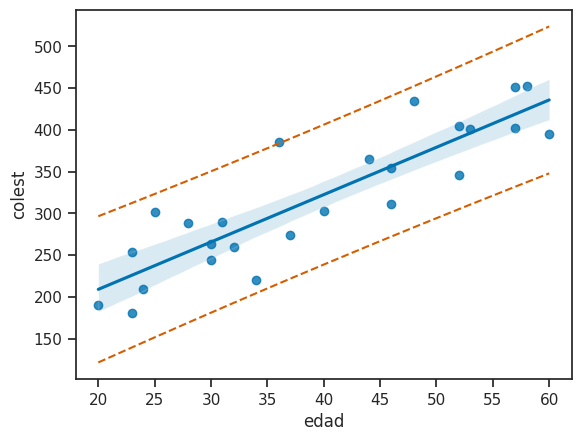

In [9]:
# Graficamos en Python
%R -o nuevos_datos

# Grafico
sns.regplot(data=nuevos_datos, x='edad', y='colest')
sns.lineplot(data=nuevos_datos, x='edad', y='lwr', linestyle='--', color='r')
sns.lineplot(data=nuevos_datos, x='edad', y='upr', linestyle='--', color='r')
plt.show()

In [10]:
# # LRM en Python
# data = dataP

# # Generamos el Modelo
# data = sm.add_constant(data)
# model = smf.ols('colest ~ edad', data=data).fit()

# # Ploteamos
# sns.regplot(data=data, x='edad', y='colest')
# plt.show()

### Wald Test (revisar)
Mide si la Variable X es lo suficientemente significativa como para explicar la

In [11]:
# #####   PENDIENTE    ######
# %%R
# data <- dataO

# library(aod)

# # Generamos el Modelo
# model_gorr = lm('Largo ~ Alas + Cabeza + Pata + Cuerpo', data=data)
# print(summary(model_gorr))

# # Wald Test para indentificar variables significativas
# wald.test(Sigma = vcov(model_gorr), b = coef(model_gorr), Terms = 4) # Cuerpo| H0: Coef = 0 (Var no significativa)


# Analisis de Diagnostico

### Residuals Nomrality

In [25]:
# %%R
# data  <- dataO
# model <- lm('Largo ~ Alas + Cabeza + Pata + Cuerpo', data=data)
# resid <- model$resid
# fitted <- model$fitted.values

# # Analisis de Normalidad en los Residuos
# library(car)
# qqPlot(resid) # Observaciones que romperian con el supuesto de Normalidad
# print(shapiro.test(resid))

In [ ]:
# # Python
# data=dataO

# # Tests Analiticos
# display(pg.normality(data['Alas'])) # Shapiro Test(single Var), H0 -> Normal Dist
# print(st.anderson(data['Alas'], dist='norm')) # Anderson-Darling SciPy
# print(st.kstest(data['Alas'], 'norm'))# Kolmogorov-Smirnov SciPy

# # Tests Graficos
# pg.qqplot(data['Alas'])
# plt.show()

### Residuals Variance (Homosedasticity)

In [ ]:
# # Analisis Analitico (Breusch-Pagan Test) -> R | H0: Residuos Homocedasticos
# %%R

# library(lmtest)
# bptest(model)

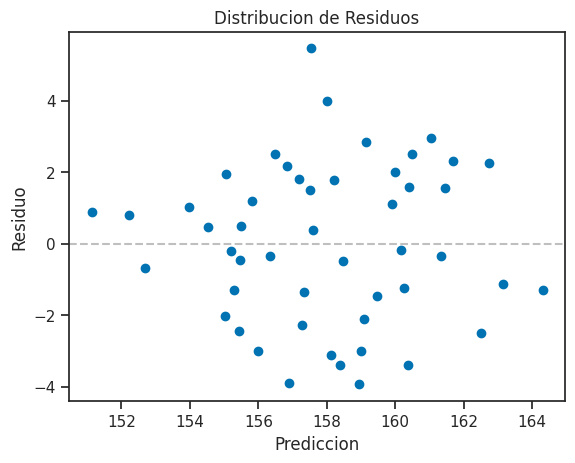

In [29]:
# # Analsis Grafico -> Python

# Importo Datos desde R
%R -o resid
%R -o fitted

plt.scatter(x=fitted, y=resid)
plt.xlabel( 'Prediccion')
plt.ylabel('Residuo')
plt.title('Distribucion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura de embudo

# # Analisis Analitico Python
# BP, p_value, _, _ =sm.stats.het_breuschpagan(model.resid, model.model.exog)
# print('Estadistico BP y p-value:', BP, p_value)

### Residuals Auto-Correlation

In [ ]:
# Analisis Analitico (Durbin-Watson Test) -> R | H0 No Auto-Correlacion
# 2=No Correlacion (Independecia)| 0=Correlacion Pos | 4=Correlacion Neg
%%R

library(lmtest)
dwtest(model, alternative='two.sided', iterations=1000)

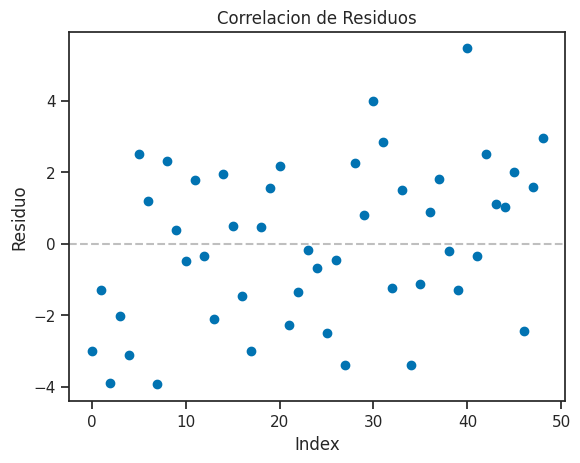

Durbin-Watson: 1.8812508254140996


In [35]:
# Analsis Grafico -> Python
%R -o resid
%R -o fitted

plt.scatter(x=data.index, y=resid)
plt.xlabel( 'Index')
plt.ylabel('Residuo')
plt.title('Correlacion de Residuos')
plt.axhline(color='grey', linestyle='dashed', alpha=0.5)
plt.show()
# No se observa estructura

# Analisis Analitico -> Python
print('Durbin-Watson:', sm.stats.durbin_watson(resid)) # Sin validacion Estadistica

# Transformaciones
- Cuando los residuos no siguen una distribucion Normal -> Transformamos la y (BoxCox)
- Cuando los residuos tienen estructura -> Transformamos/Agregamos X

In [ ]:
# Box Cox Transformation -> R
%%R
data = dataC
library(MASS)

# Modelo existente
model<- lm('dist ~ speed', data=data)

# Buscamos el Lambda  optimo -> Si Lambda  = 0 -> log10(y) | y**Lambda
boxcox(object = model, plotit=TRUE)

In [ ]:
# # Generamos el nuevo modelo con las nuevas variables transformadas, y veridicamos su Normalidad
%%R

lmb = 0.5

model_2 <- lm('dist**lmb ~ speed', data=data)
print(shapiro.test(model_2$resid))

# Bandas de Prediccion
predichos <- predict(object=model_2, interval='prediction', level=0.95)
nuevos_datos <- data.frame(predichos, data, data$dist**lmb)
print(head(nuevos_datos))

# # Reverse Transformation
# base = 2
# exp = 3
# print(base**exp)
# print(log(base**exp, base))

In [ ]:
# Graficamos con las Bandas de Confianza y Prediccion
%R -o nuevos_datos # Exportamos desde R
%R -o lmb

sns.regplot(data=nuevos_datos, x='speed', y='data.dist.lmb')
sns.lineplot(data=nuevos_datos, x='speed', y='lwr', linestyle='--', color='r')
sns.lineplot(data=nuevos_datos, x='speed', y='upr', linestyle='--', color='r')
plt.ylabel('Transformed Distance')
plt.show()

In [ ]:
# # Boc Cox Transformation -> Python
# data = dataC
# y = data['dist']

# # Calculo Lambda
# maxlog = st.boxcox(y)[1]
# st.boxcox_normplot(y, -2, 2, plt)
# plt.axvline(maxlog, color='red')
# plt.show()

# Deteccion de Valores Outliers e Influyentes

In [ ]:
# %%R
# data <- dataU
# # library(car)

# # Generamos un modelo base
# model <- lm('nassets ~ stfees', data=data)
# resid = model$resid
# predicted = predict(model)
# fitted = model$fitted.values

# # Outliers - Bonferroni
# qqPlot(resid)
# outlierTest(model)
# influenceIndexPlot(model, vars='Bonf')

# # Influyentes - Leverage
# crit_leverage <- 3*mean(hatvalues(model))
# leverage <- hatvalues(model) > crit_leverage
# leverage_data <- data.frame(cbind(hatvalues(model), crit_leverage, leverage))
# print(subset(leverage_data, leverage==1))
# # hist(hatvalues(model))

# # Influyentes - Cook
# # print(cooks.distance(model))
# influenceIndexPlot(model, vars='Cook')

# # Influyentes - DFFITS
# p <- length(model$coef)
# n <- NROW(model$resid)
# dffits_crit <- 2*sqrt(p/n)
# dffits <- dffits(model)
# data_dffits <- data.frame(dffits=dffits)

# # Influyentes - DFBetas
# dfbetas_crit <- 1 # Umbral estandard
# dfbetas_data <- dfbetas(model)[,2]>dfbetas_crit
# print(which(dfbetas_data))


# # Resumen
# plot(model)
# summary(influence.measures(model=model))
# influencePlot(model = model)

In [ ]:
# # DFFITS Grafico -> Python
# %R -o data_dffits
# %R -o dffits_crit

# # Grafico
# data_dffits.head()
# sns.scatterplot(data=data_dffits, x=data_dffits.index, y='dffits')
# plt.axhline(y=dffits_crit, linestyle='--', color='red')
# plt.axhline(y=-dffits_crit, linestyle='--', color='red')
# plt.xticks(rotation=45)
# plt.show()

# # Filtro los criticos
# dffits_crit_low = -dffits_crit
# dffits_crit_up = dffits_crit

# display(data_dffits.query('dffits > @dffits_crit_up or dffits < @dffits_crit_low'))

# Cuadrados Minimos Ponderados (WLS)
- Cuando los residuos son Heterocedasticos
- Se compensa la diferencia en los residuos, asignandole diferentes pesos a las observaciones

In [ ]:
# # Cuadrados Minimos Ponderados (WLS) en R
# %%R
# data <- dataU
# library(lmtest)

# # Generamos un modelo base
# model_ols <- lm('nassets ~ stfees', data=data)

# # Generamos la ponderacion de pesos y modelamos de nuevo
# peso1 = 1 / lm(abs(model_ols$resid) ~ model_ols$fitted.values)$fitted.values**2 # Funciona mejor
# peso2 = 1 / model_ols$fitted.values**2 # A los valores mas alejados se le reduce el peso

# # Modelamos con lo weigths
# model_wls1 <- lm('nassets ~ stfees', data=data, weights=peso1)
# model_wls2 <- lm('nassets ~ stfees', data=data, weights=peso2)

# # Comparamos los modelos
# plot(data$stfees, data$nassets, xlab='stfees', ylab='nassets', main='OLS vs WLS')
# abline(model_ols, col='black')
# abline(model_wls1, col='blue')
# abline(model_wls2, col='red')
